In [ ]:
# ! pip install sympy 
# ! pip install networkx 
# ! pip install matplotlib 
# ! pip install pyqubo 
# ! pip install gurobipy

In [7]:
from sympy import symbols, Matrix, simplify, Add, Mul
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import random

In [8]:
def generate_problem_instance(num_nodes, weight_range=(-1, 1)):
    """
    Generate a random problem instance for the min-cut problem.
    :param num_nodes: Number of nodes in the graph.
    :param weight_range: Range of weights for the edges (tuple, inclusive).
    :return: Dictionary {(i, j): weight} representing the edges and their weights.
    """
    edge_dict = {}
    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            weight = round(random.uniform(weight_range[0], weight_range[1]), 2)
            edge_dict[(i, j)] = weight
    return edge_dict

In [37]:
# Example usage: Generate a graph with 5 nodes
num_nodes = 3
edge_dict = generate_problem_instance(num_nodes)
edge_dict

{(1, 2): -0.08, (1, 3): 0.08, (2, 3): 0.2}

In [42]:
# Example dictionary input
edge_dict = {
    (1, 2): -2,
    (1, 3): 8,
    (2, 3): -3
}

edge_dict

{(1, 2): -2, (1, 3): 8, (2, 3): -3}

In [43]:
nodes = set()

for edge in edge_dict.keys():
    nodes.update(edge)
nodes = sorted(nodes)
node_index = {node: i for i, node in enumerate(nodes)}

size = len(nodes)
adjacency_matrix = Matrix.zeros(size, size)

for (u, v), weight in edge_dict.items():
    i, j = node_index[u], node_index[v]
    adjacency_matrix[i, j] = weight
    adjacency_matrix[j, i] = weight  # Symmetric matrix for undirected graph

In [44]:
adjacency_matrix

Matrix([
[ 0, -2,  8],
[-2,  0, -3],
[ 8, -3,  0]])

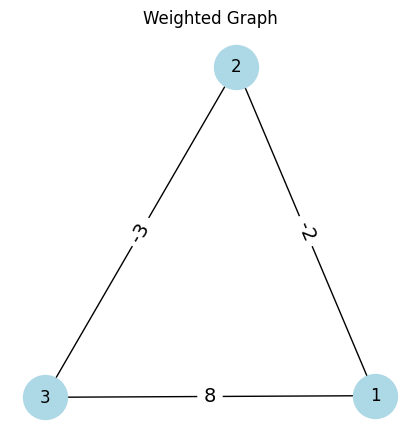

In [45]:
plt.figure(figsize=(4,4))
G = nx.Graph()

for (u, v), weight in edge_dict.items():
    G.add_edge(u, v, weight=weight)

# Create a fixed layout for the graph
pos = nx.spring_layout(G, seed=111)  # Set a seed for reproducibility

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1000)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=14)
plt.title("Weighted Graph")
plt.show()

# Formulate the QUBO (Quadratic Unconstrained Binary Optimization) Problem

The MinCut problem can be written as:
$$
\text{Objective: } \min_x \sum_{i,j} w_{ij} x_i (1 - x_j)
$$

In [46]:
n = adjacency_matrix.shape[0]
x = symbols(f"x1:{n+1}")

for i in range(n):
    for j in range(n):
        display(adjacency_matrix[i, j] * x[i] * (1 - x[j]))

qubo_expr = sum([adjacency_matrix[i, j] * x[i] * (1 - x[j]) for i in range(n) for j in range(n)])

qubo_expr

0

-2*x1*(1 - x2)

8*x1*(1 - x3)

-2*x2*(1 - x1)

0

-3*x2*(1 - x3)

8*x3*(1 - x1)

-3*x3*(1 - x2)

0

-2*x1*(1 - x2) + 8*x1*(1 - x3) - 2*x2*(1 - x1) - 3*x2*(1 - x3) + 8*x3*(1 - x1) - 3*x3*(1 - x2)

In [47]:
simplified_qubo = simplify(qubo_expr)
simplified_qubo

4*x1*x2 - 16*x1*x3 + 6*x1 + 6*x2*x3 - 5*x2 + 5*x3

In [48]:
x1, x2 = symbols('x1 x2')
term = 0.18 * x1 * x2

# term.coeff()



In [49]:
from sympy import symbols

# Define the variables
x1, x2 = symbols('x1 x2')

# Example term
term = 0.18 * x1 * x2

# Extract the coefficient of the specific term (x1 * x2)
coefficient = term.coeff(Mul(*(term.free_symbols)))

print("Term:", term)
print("Coefficient:", coefficient)


Term: 0.18*x1*x2
Coefficient: 0.180000000000000


In [50]:
# Extract coefficients for QUBO matrix
Q = Matrix.zeros(n, n)
for term in simplified_qubo.as_ordered_terms():
    variables = term.free_symbols
    coeff = term.coeff(Mul(*(variables)))
    if len(variables) == 1:  # Diagonal terms (linear coefficients)
        var = list(variables)[0]
        idx = int(str(var)[1:]) - 1
        Q[idx, idx] += coeff
    elif len(variables) == 2:  # Off-diagonal terms (quadratic coefficients)
        var1, var2 = sorted(variables, key=lambda v: int(str(v)[1:]))
        idx1, idx2 = int(str(var1)[1:]) - 1, int(str(var2)[1:]) - 1
        Q[idx1, idx2] += coeff # Account for symmetry
        Q[idx2, idx1] += coeff
Q

Matrix([
[  6,  4, -16],
[  4, -5,   6],
[-16,  6,   5]])

# Solving the QUBO Problem

The goal is to find a binary vector $x$ such that:
$$
\min_x\ x^T Q x
$$

We will evaluate all possible binary vectors $ x $ (for small problem sizes) and compute the cost function value for each.


$(1 \times 3) \times (3 \times 3) \times (3 \times 1)$ = $(1 \times 1)$

In [51]:
n = Q.shape[0]
x_symbols = symbols(f"x1:{n+1}")
all_possible_vectors = [Matrix([int(b) for b in f"{i:0{n}b}"]) for i in range(2**n)]
min_cost = float('inf')
optimal_vector = None
for x in all_possible_vectors:
    cost = (x.T * Q * x)[0]  # Evaluate cost function
    print(x, cost)
    if cost < min_cost:
        min_cost = cost
        optimal_vector = x

Matrix([[0], [0], [0]]) 0
Matrix([[0], [0], [1]]) 5
Matrix([[0], [1], [0]]) -5
Matrix([[0], [1], [1]]) 12
Matrix([[1], [0], [0]]) 6
Matrix([[1], [0], [1]]) -21
Matrix([[1], [1], [0]]) 9
Matrix([[1], [1], [1]]) -6


In [96]:
optimal_vector, min_cost

(Matrix([
 [1],
 [0],
 [1]]),
 -21)

# Visualization of the Optimal Cut

The optimal binary vector partitions the graph into two sets:
- Nodes with $ x_i = 0 $
- Nodes with $ x_i = 1 $

We can highlight the edges in the cut using different colors.


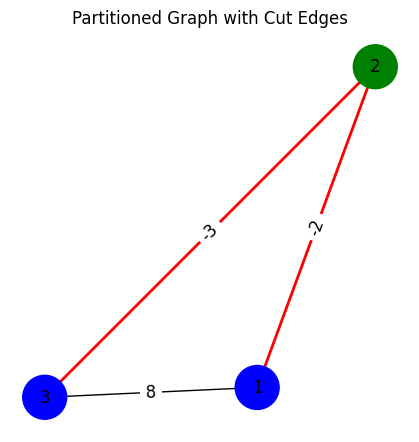

In [97]:
# Identify nodes in each partition
partition_0 = [i + 1 for i, val in enumerate(optimal_vector) if val == 0]
partition_1 = [i + 1 for i, val in enumerate(optimal_vector) if val == 1]

# Assign colors to nodes based on partition
node_colors = []
for node in G.nodes:
    if node in partition_0:
        node_colors.append("green")  # Nodes in partition 0
    elif node in partition_1:
        node_colors.append("blue")   # Nodes in partition 1

# Highlight the edges in the cut
cut_edges = [(u, v) for u, v in G.edges if (u in partition_0 and v in partition_1) or (u in partition_1 and v in partition_0)]

# Plot the graph with node colors and cut edges
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color="red", width=2)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
plt.title("Partitioned Graph with Cut Edges")
plt.show()


In [98]:
from pyqubo import Array, solve_qubo
import numpy as np

In [99]:
# Create binary variables
x = Array.create('x', shape=Q.shape[0], vartype='BINARY')

# Formulate the QUBO model
qubo_model = sum(Q[i, j] * x[i] * x[j] for i in range(Q.shape[0]) for j in range(Q.shape[1]))
qubo_model = qubo_model.compile()

# Generate the QUBO dictionary
qubo, offset = qubo_model.to_qubo()

# Solve the QUBO problem using the default solver
solution = solve_qubo(qubo)

# Extract results
optimal_solution = np.array([solution[f'x[{i}]'] for i in range(Q.shape[0])])
print("Optimal solution (binary vector):", optimal_solution)
print("Optimal cost:", sum(Q[i, j] * optimal_solution[i] * optimal_solution[j] for i in range(Q.shape[0]) for j in range(Q.shape[1])))

Optimal solution (binary vector): [1 0 1]
Optimal cost: -21


C:\Users\mysore\AppData\Local\Temp\ipykernel_11820\229288507.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) solve_qubo. (You should use simulated annealing sampler of dwave-neal directly.) -- Deprecated since version 0.4.0.
  solution = solve_qubo(qubo)


In [102]:
import gurobipy as gp
from gurobipy import GRB

In [103]:
# Initialize Gurobi model
model = gp.Model("QUBO")

# Create binary variables
n = Q.shape[0]
x = model.addVars(n, vtype=GRB.BINARY, name="x")

# Add the objective function
objective = gp.QuadExpr()
for i in range(n):
    for j in range(n):
        objective += Q[i, j] * x[i] * x[j]

model.setObjective(objective, GRB.MINIMIZE)

# Optimize the model
model.optimize()

# Extract the optimal solution
optimal_solution = np.array([x[i].x for i in range(n)])
print("Optimal solution (binary vector):", optimal_solution)
print("Optimal cost:", model.objVal)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12800H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 0 rows, 3 columns and 0 nonzeros
Model fingerprint: 0x4556297e
Model has 6 quadratic objective terms
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -6.0000000
Found heuristic solution: objective -21.0000000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 20 available processors)

Solution count 3: -21 -6 

# QAOA Solver (Qiskit)

In [119]:
from qiskit.circuit.library import Diagonal
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit.result import QuasiDistribution

from qiskit_algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals

In [120]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    cost = 0
    for i in range(len(x)):
        for j in range(len(x)):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    return cost

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

def sample_most_likely(state_vector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

In [121]:
def qaoa_solver(G, reps=1):
  n = G.number_of_nodes()
  w = -1 * nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  # print(qp.prettyprint())
  qubitOp, offset = qp.to_ising()
  sampler = Sampler()
  algorithm_globals.random_seed = 123
  optimizer = COBYLA()
  qaoa = QAOA(sampler, optimizer, reps=reps)
  result = qaoa.compute_minimum_eigenvalue(qubitOp)
  x = sample_most_likely(result.eigenstate)
  return x, objective_value(x, w)

In [123]:
qaoa_solver(G, reps=1)

C:\Users\mysore\AppData\Local\Temp\ipykernel_11820\3735664337.py:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


(array([0, 1, 0]), np.int64(5))